In [1]:
import matplotlib.cm as cm  # Para manejar mapas de colores
import matplotlib.pyplot as plt  # Para crear gráficos
import numpy as np  # Para manipulación numérica y matrices

In [2]:
# Importación de modelos de clustering y utilidades de sklearn
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.utils import check_random_state, shuffle

In [3]:
# Inicialización del generador de números aleatorios
random_state = np.random.RandomState(0)

In [4]:
# Número de ejecuciones para cada estrategia, necesario para calcular
# una estimación de la desviación estándar
n_runs = 5

In [5]:
# Los modelos de k-means pueden realizar varias inicializaciones aleatorias
# para mejorar la robustez de la convergencia intercambiando tiempo de CPU
n_init_range = np.array([1, 5, 10, 15, 20])

In [6]:
# Parámetros para la generación de datos
n_samples_per_center = 100  # Número de muestras por centro
grid_size = 3  # Tamaño de la cuadrícula
scale = 0.1  # Escala de ruido
n_clusters = grid_size ** 2  # Número total de clusters

In [7]:
# Función para generar datos aleatorios en torno a centros distribuidos en una cuadrícula
def make_data(random_state, n_samples_per_center, grid_size, scale):
    random_state = check_random_state(random_state)  # Verificación del estado aleatorio
    # Creación de centros distribuidos en una cuadrícula de tamaño grid_size x grid_size
    centers = np.array([[i, j] for i in range(grid_size) for j in range(grid_size)])
    n_clusters_true, n_features = centers.shape  # Determina el número de clusters y características

    # Genera ruido gaussiano alrededor de los centros
    noise = random_state.normal(
        scale=scale, size=(n_samples_per_center, centers.shape[1])
    )

    # Crea los datos desplazando los centros por el ruido
    X = np.concatenate([c + noise for c in centers])
    # Asigna etiquetas (y) según el centro correspondiente
    y = np.concatenate([[i] * n_samples_per_center for i in range(n_clusters_true)])
    
    # Mezcla las muestras y las etiquetas de manera aleatoria
    return shuffle(X, y, random_state=random_state)

In [8]:
# Parte 1: Evaluación cuantitativa de varios métodos de inicialización

plt.figure()  # Inicia una nueva figura para los gráficos
plots = []  # Almacena los objetos de gráficos
legends = []  # Almacena las leyendas correspondientes

<Figure size 640x480 with 0 Axes>

In [9]:
# Diferentes casos a evaluar, especificando el modelo, la inicialización, los parámetros y el formato del gráfico
cases = [
    (KMeans, "k-means++", {}, "^-"),
    (KMeans, "random", {}, "o-"),
    (MiniBatchKMeans, "k-means++", {"max_no_improvement": 3}, "x-"),
    (MiniBatchKMeans, "random", {"max_no_improvement": 3, "init_size": 500}, "d-"),
]

Evaluación de KMeans con inicialización k-means++
Evaluación de KMeans con inicialización random
Evaluación de MiniBatchKMeans con inicialización k-means++
Evaluación de MiniBatchKMeans con inicialización random


Text(0.5, 1.0, 'Inercia promedio para varios métodos de k-means en 5 ejecuciones')

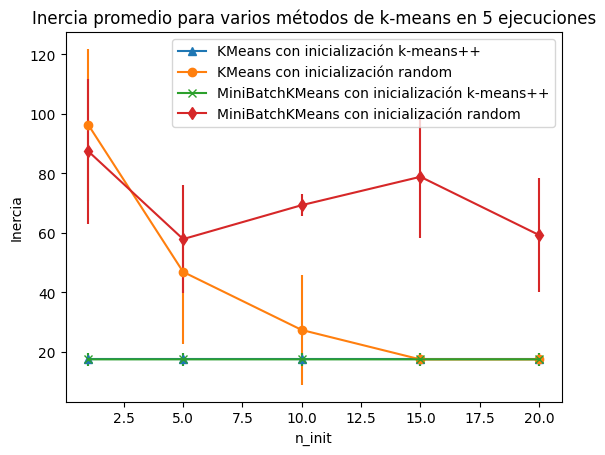

In [10]:
# Itera sobre los diferentes casos de k-means a evaluar
for factory, init, params, format in cases:
    print("Evaluación de %s con inicialización %s" % (factory.__name__, init))
    inertia = np.empty((len(n_init_range), n_runs))  # Matriz para almacenar las inercia

    # Realiza varias ejecuciones con datos generados aleatoriamente
    for run_id in range(n_runs):
        X, y = make_data(run_id, n_samples_per_center, grid_size, scale)
        
        # Itera sobre los valores de inicializaciones y ajusta el modelo
        for i, n_init in enumerate(n_init_range):
            km = factory(
                n_clusters=n_clusters,  # Número de clusters
                init=init,  # Método de inicialización (k-means++ o aleatorio)
                random_state=run_id,  # Estado aleatorio para reproducibilidad
                n_init=n_init,  # Número de inicializaciones
                **params,  # Parámetros adicionales
            ).fit(X)  # Ajusta el modelo con los datos generados
            inertia[i, run_id] = km.inertia_  # Guarda la inercia del modelo

    # Grafica los valores promedio y desviación estándar de la inercia
    p = plt.errorbar(
        n_init_range, inertia.mean(axis=1), inertia.std(axis=1), fmt=format
    )
    plots.append(p[0])  # Guarda el gráfico
    legends.append("%s con inicialización %s" % (factory.__name__, init))  # Guarda la leyenda

# Etiquetas de los ejes y título del gráfico
plt.xlabel("n_init")
plt.ylabel("Inercia")
plt.legend(plots, legends)
plt.title("Inercia promedio para varios métodos de k-means en %d ejecuciones" % n_runs)

In [11]:
# Parte 2: Inspección cualitativa de la convergencia

# Genera un conjunto de datos para una inspección visual
X, y = make_data(random_state, n_samples_per_center, grid_size, scale)

In [12]:
# Ajusta el modelo MiniBatchKMeans con inicialización aleatoria
km = MiniBatchKMeans(
    n_clusters=n_clusters, init="random", n_init=1, random_state=random_state
).fit(X)

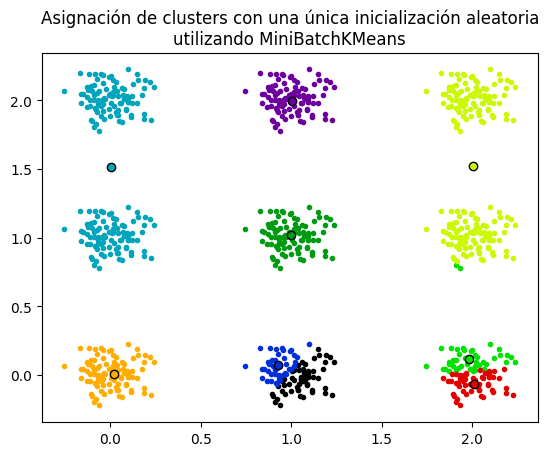

In [13]:
plt.figure()  # Inicia una nueva figura para el gráfico

# Visualización de los clusters obtenidos
for k in range(n_clusters):
    my_members = km.labels_ == k  # Obtiene los puntos asignados al cluster k
    color = cm.nipy_spectral(float(k) / n_clusters, 1)  # Asigna un color al cluster
    plt.plot(X[my_members, 0], X[my_members, 1], ".", c=color)  # Grafica los puntos del cluster
    cluster_center = km.cluster_centers_[k]  # Obtiene el centro del cluster
    # Grafica el centro del cluster
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=color,
        markeredgecolor="k",
        markersize=6,
    )
    # Título para el gráfico
    plt.title(
        "Asignación de clusters con una única inicialización aleatoria\nutilizando MiniBatchKMeans"
    )

plt.show()